# Description

You are provided with an anonymized dataset containing numeric feature variables, the binary target column, and a string ID_code column. The task is to predict the value of target column in the test set. To download the dataset make sure you have kaggle api installed on your machine.

    kaggle competitions download -c santander-customer-transaction-prediction


In [1]:
import pandas as pd
import numpy as np

## Setting up dask

In [ ]:
from dask.distributed import Client, progress
from joblib import Parallel, parallel_backend

client = Client(processes=False, threads_per_worker=4,
                n_workers=2, memory_limit='6GB')
client

In [ ]:
client.stop()

## Read train data

In [2]:
train = pd.read_csv('./data/train.csv.zip',compression='zip', header=0, sep=',', quotechar='"')

In [3]:
train.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
m,n = train.shape
print("shape of train dataframe {}, {}".format(m,n))

shape of train dataframe 200000, 202


In [5]:
train.dropna().shape

(200000, 202)

# Distribution of target classes

In [6]:
train.target.value_counts()

0    179902
1     20098
Name: target, dtype: int64

# Describe 

In [8]:
train.loc[:, train.dtypes == np.float64].boxplot(figsize=(24,12), rot = 90)

In [9]:
# Identify feature columns

columns_to_select = [cols for cols in train.columns.values.tolist() if cols not in ['ID_code','target']]

In [10]:
%%time
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train[columns_to_select] = scaler.fit_transform(train[columns_to_select])

CPU times: user 7.62 s, sys: 7.28 s, total: 14.9 s
Wall time: 19.6 s


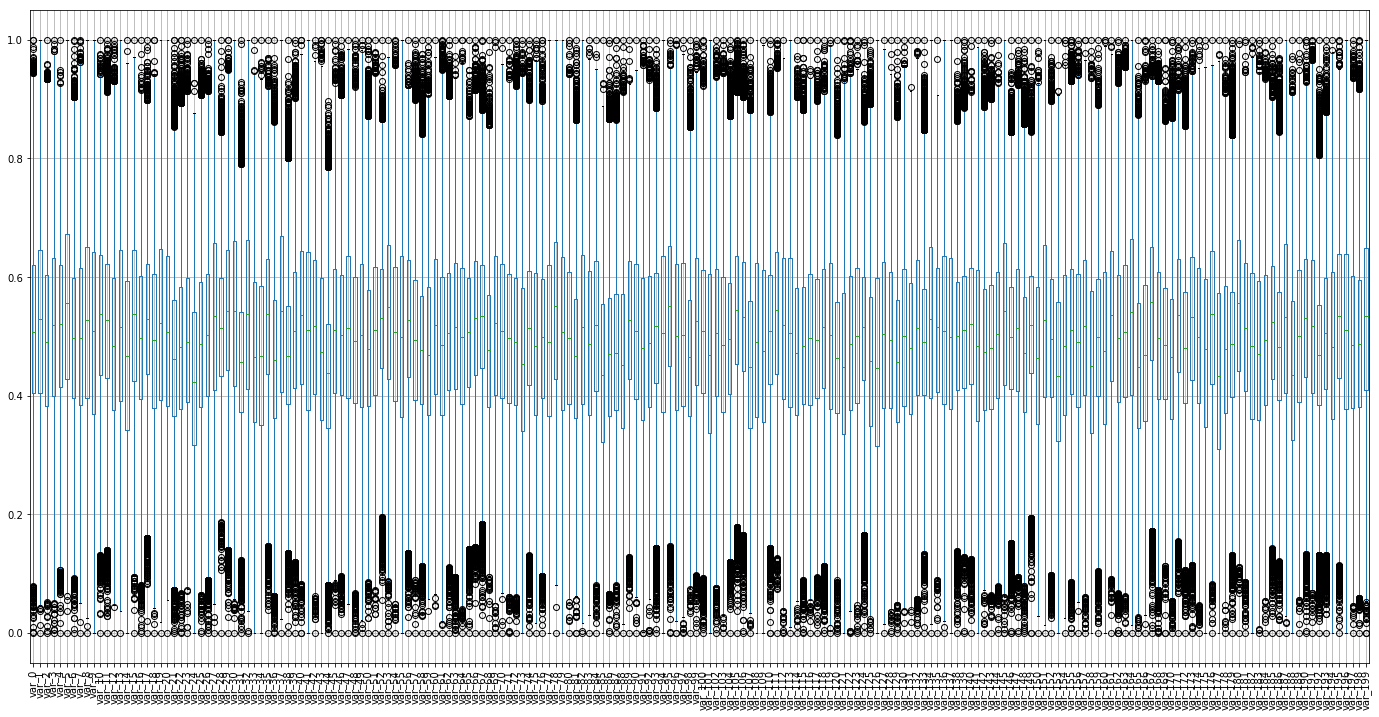

In [11]:
train.loc[:, train.dtypes == np.float64].boxplot(figsize=(24,12), rot = 90)

# Split to train and test data

In [12]:
from sklearn.model_selection import train_test_split

xs = train[columns_to_select]
ys = train['target']

x_train, x_test, y_train, y_test = train_test_split(xs, ys,
                                                    test_size=0.33,
                                                    random_state=0,
                                                    stratify=ys)

# Smote analysis

In [13]:
from imblearn.over_sampling import SMOTE

In [14]:
%%time
smt = SMOTE()
X_train, Y_train = smt.fit_sample(x_train, y_train)

CPU times: user 2min 22s, sys: 2.77 s, total: 2min 25s
Wall time: 2min 31s


In [15]:
np.bincount(Y_train)

array([120534, 120534])

from sklearn.model_selection

## Model fitting

In [16]:
from sklearn.ensemble import RandomForestClassifier
import pickle

In [17]:
clf = RandomForestClassifier(n_estimators=500, max_depth =10, random_state=0, n_jobs=-1)

In [19]:
%%time
clf.fit(X_train,Y_train)

CPU times: user 51min 5s, sys: 12.9 s, total: 51min 18s
Wall time: 13min 33s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## Saving the model

In [20]:
with open('./model/rf_model_normalized_columns.pkl','wb') as f:
    pickle.dump(clf, f) 

## Loading the model

In [18]:
with open('./model/rf_model_normalized_columns.pkl','rb') as f:
    clf = pickle.load(f)

In [21]:
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, recall_score

y_pred = clf.predict(x_test)
print("accuracy: {}".format(accuracy_score(y_test, y_pred)))
print("precision score: {}".format(average_precision_score(y_pred,y_test)))

accuracy: 0.7971515151515152
precision score: 0.21388444516413135


In [22]:
confusion_matrix(y_test, y_pred)

array([[50212,  9156],
       [ 4232,  2400]])